In [3]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import beta as B
from scipy.special import betaln as lnB

Question 1

In [4]:
data = np.loadtxt('binarydigits.txt')

In [5]:
def learn_pML(data):
    N, D = data.shape
    pML = (1/N)*np.sum(data, axis=0)
    return pML

def learn_pMAP(data, alpha, beta):
    N, D = data.shape
    pML = learn_pML(data)
    # pMAP = (pML + alpha - 1)/(alpha + beta - 1)
    pMAP = (N*pML + alpha - 1)/(N + alpha + beta - 2)
    return pMAP

def plot_pixels(data, title=''):
    plt.figure()
    plt.imshow(np.reshape(data, (8,8)), vmin=0, vmax=1, interpolation='None', cmap='grey')
    plt.title(title)


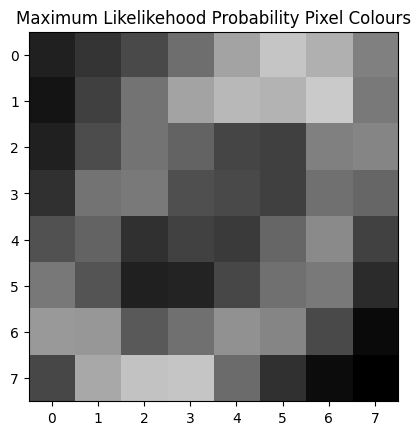

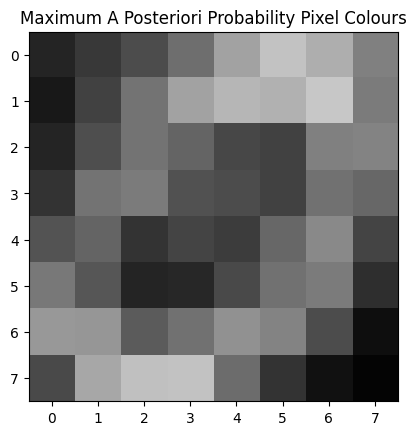

In [6]:
pML = learn_pML(data)
plot_pixels(pML, "Maximum Likelikehood Probability Pixel Colours")

pMAP = learn_pMAP(data, 3.0, 3.0)
plot_pixels(pMAP, "Maximum A Posteriori Probability Pixel Colours")

Question 2

In [7]:
N, D = map(int, data.shape)

alpha = 1 + np.sum(data)
beta = N*D + 1 - alpha
alpha_d = 1 + np.sum(data, axis=0)
beta_d = N - alpha_d

log_prob_model_a = N*D*np.log((0.5))
log_prob_model_b = lnB(alpha, beta)
log_prob_model_c = np.sum(lnB(alpha_d, beta_d))

avg_log_prob_model = np.mean([log_prob_model_a, log_prob_model_b, log_prob_model_c])

rel_prob_model_a = np.exp(log_prob_model_a - avg_log_prob_model)
rel_prob_model_b = np.exp(log_prob_model_b - avg_log_prob_model)
rel_prob_model_c = np.exp(log_prob_model_c - avg_log_prob_model)

# print('log_prob_model_a : log_prob_model_b : log_prob_model_c = ', log_prob_model_a, ':', log_prob_model_b, ':', log_prob_model_c)

print('(relative) prob_model_a : prob_model_b : prob_model_c = ', rel_prob_model_a, ':', rel_prob_model_b, ':', rel_prob_model_c)

(relative) prob_model_a : prob_model_b : prob_model_c =  3.79475594665626e-118 : 9.755326203651874e-52 : 2.701309548088313e+168


Question 3

Import Libraries and Data

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
data = np.loadtxt('binarydigits.txt')

Define Functions

In [9]:
def param_init(K, X):
    """
    K   : scalar representing number of mixtures
    X   : NxD matrix of data points
    pi  : 1xK vector of mixture fractions
    P   : KxD matrix of parameters
    """
    _, D = X.shape
    pi = np.ones(K)/K
    P = np.random.rand(K, D)
    P = np.clip(P, 1e-10, 1-1e-10)
    return pi, P

def calc_log_likelihood(pi, P, X):
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    l       : NxK matrix of log likelihood values
    """
    l = X@np.log(P).T + (1-X)@np.log(1-P).T
    return l

def update_log_r(pi, P, X):
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    r       : NxK matrix of responsibilities
    """
    log_likelihood = calc_log_likelihood(pi, P, X)
    log_prior = np.log(pi)[None, :]
    log_prob = log_likelihood + log_prior
    mixture_log_likelihood = logsumexp(log_prob, axis=1, keepdims=True)

    log_r = log_prob - mixture_log_likelihood
    total_log_likelihood = np.sum(mixture_log_likelihood)
    return log_r, total_log_likelihood

def update_P_d(r, X_d):
    """
    r       : NxK matrix of responsibilities   
    X_d     : Nx1 vector of Dth column of data points in X
    P_d     : Kx1 vector of Dth column of parameters in P
    """
    num = r.T@X_d
    den = np.sum(r, axis = 0)
    P_d = num/den
    return P_d


def update_pi(r, X):
    """
    r   : NxK matrix of responsibilities
    X   : NxD matrix of data points
    pi  : 1xK vector of mixture fractions
    """
    N, _ = X.shape
    pi = np.sum(r, axis=0)/N
    return pi


def e_step(pi, P, X):
    """
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    X       : NxD matrix of data points
    r       : NxK matrix of responsibilities
    total_l : scalar value representing total mixture log likelihood
    """
    log_r, total_l = update_log_r(pi, P, X)
    r = np.exp(log_r)
    return r, total_l


def m_step(r, X):
    """
    r       : NxK matrix of responsibilities
    X       : NxD matrix of data points
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    """
    pi = update_pi(r, X)
    _, D = X.shape
    _, K = r.shape
    P = np.zeros((K, D))
    for d in range(D):
        P[:, d] = update_P_d(r, X[:, d])
    P = np.clip(P, 1e-10, 1-1e-10)
    return pi, P


def em_run(K, X, max_iter=200, tol=1e-10):
    """
    K       : scalar representing number of mixtures
    X       : NxD matrix of data points
    pi      : 1xK vector of mixture fractions
    P       : KxD matrix of parameters
    total_l : scalar value representing total mixture log likelihood
    i       : scalar representing number of completed iterations
    """
    pi, P = param_init(K, X)
    l_history = []
    delta = np.inf
    total_l_prev = -np.inf
    i = 0
    while i<max_iter and delta>tol:
        r, total_l = e_step(pi, P, X)
        pi, P = m_step(r, X)
        delta = total_l - total_l_prev
        l_history += [total_l]
        total_l_prev = total_l
        i += 1
    return pi, P, r, total_l, i, l_history


Run EM Loop and Create Plots

Number of Mixtures: 2
Iterations Completed: 24
Final Log Likelihood: -3320.377517023555
Mixture weights: [0.34037765 0.65962235]

Number of Mixtures: 3
Iterations Completed: 13
Final Log Likelihood: -3114.8987991794243
Mixture weights: [0.13999973 0.26999901 0.59000127]

Number of Mixtures: 4
Iterations Completed: 17
Final Log Likelihood: -3060.493857531099
Mixture weights: [0.43003518 0.2699913  0.24997352 0.05      ]

Number of Mixtures: 7
Iterations Completed: 41
Final Log Likelihood: -2527.416143224286
Mixture weights: [0.19000723 0.12020523 0.06979484 0.23       0.20999277 0.03       0.14999992]

Number of Mixtures: 10
Iterations Completed: 14
Final Log Likelihood: -2306.0638313713325
Mixture weights: [0.13960203 0.02       0.02       0.18999965 0.1        0.06000035 0.17       0.02       0.12       0.16039797]

[4791, 4494, 4416, 3647, 3327]


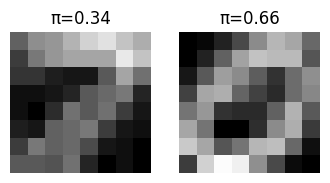

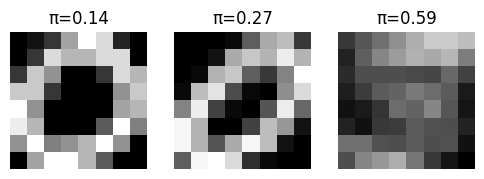

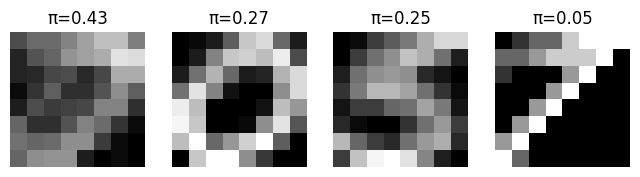

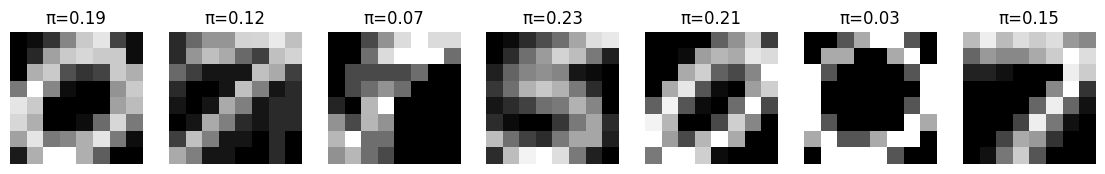

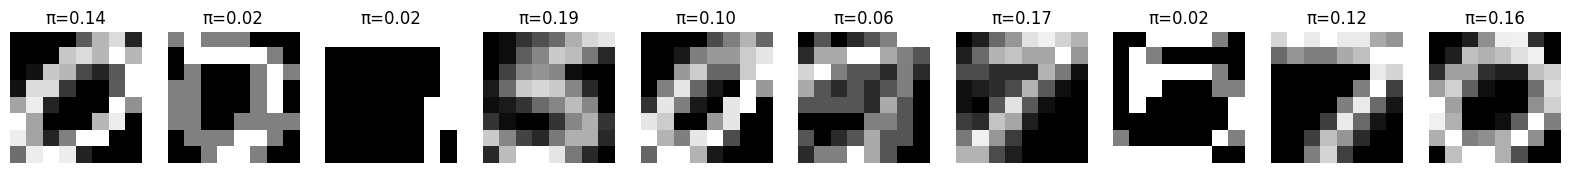

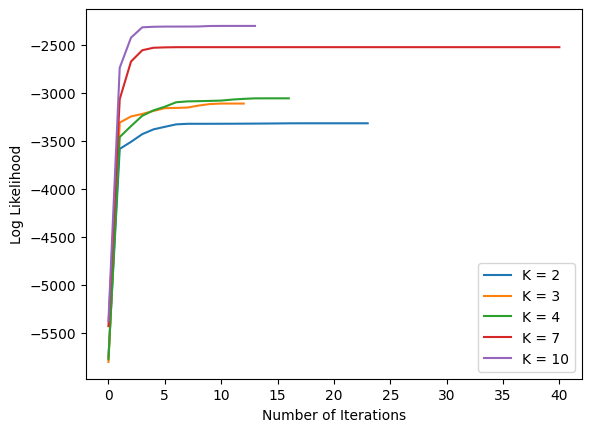

In [10]:
np.set_printoptions(linewidth=200)

mixtures = [2, 3, 4, 7, 10]
bits = []
plt.figure(1)
for idxK, K in enumerate(mixtures):

    pi, P, r, log_likelihood, iteration, l_history = em_run(K, data)

    bits += [int(np.ceil(-log_likelihood/np.log(2)))]
    print('Number of Mixtures: ' + str(K))
    print('Iterations Completed:', iteration)
    print('Final Log Likelihood:', log_likelihood)
    print('Mixture weights:', pi)
    print("")

    plt.figure(idxK+2, figsize=(2*K, 3))
    for k in range(K):
        plt.subplot(1, K, k+1)
        plt.imshow(P[k].reshape(8,8), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
        plt.title(f"π={pi[k]:.2f}")
        plt.axis('off')

    plt.figure(1)
    plt.plot(l_history, label='K = ' + str(K))
    plt.ylabel('Log Likelihood')
    plt.xlabel('Number of Iterations')
    plt.legend(loc = 'lower right')


print(bits)

Run Repeated EM Loops and Create Plots

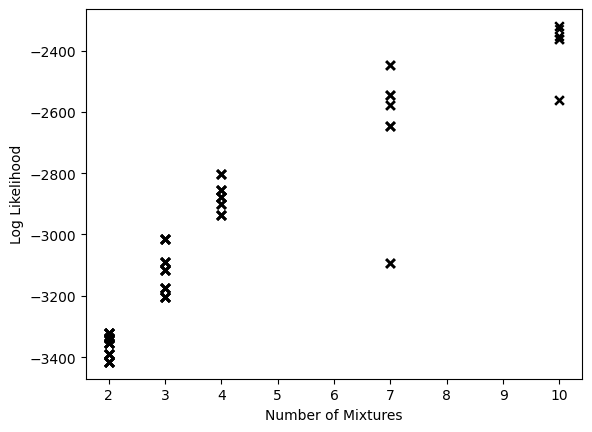

In [11]:
n_repeats = 5

bits = []
ll_arr = []
K_arr = []
plt.figure()
for idxK, K in enumerate(mixtures):
    for repeat in range(n_repeats):
        pi, P, r, log_likelihood, iteration, l_history = em_run(K, data)
        ll_arr += [log_likelihood]
        K_arr += [K]
        bits += [int(np.ceil(-log_likelihood/np.log(2)))]
        plt.scatter(K_arr, ll_arr, marker='x', c='k')
        plt.ylabel('Log Likelihood')
        plt.xlabel('Number of Mixtures')

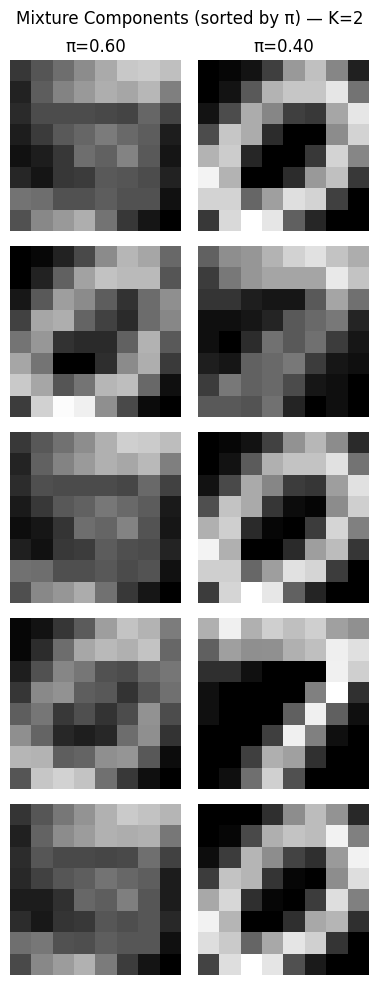

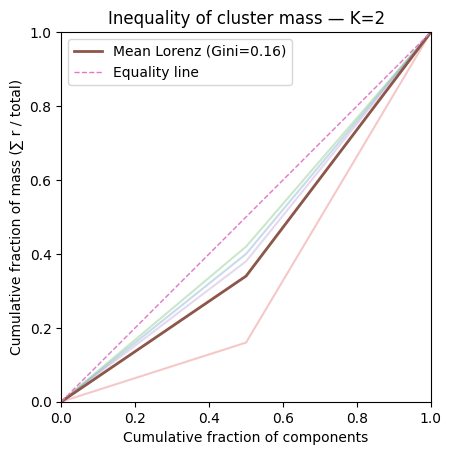

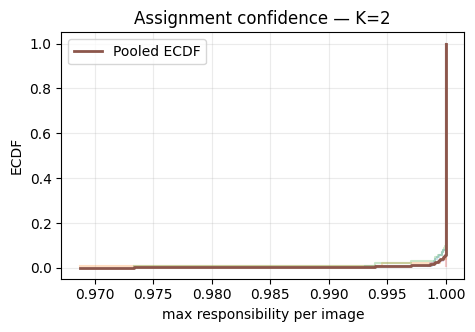

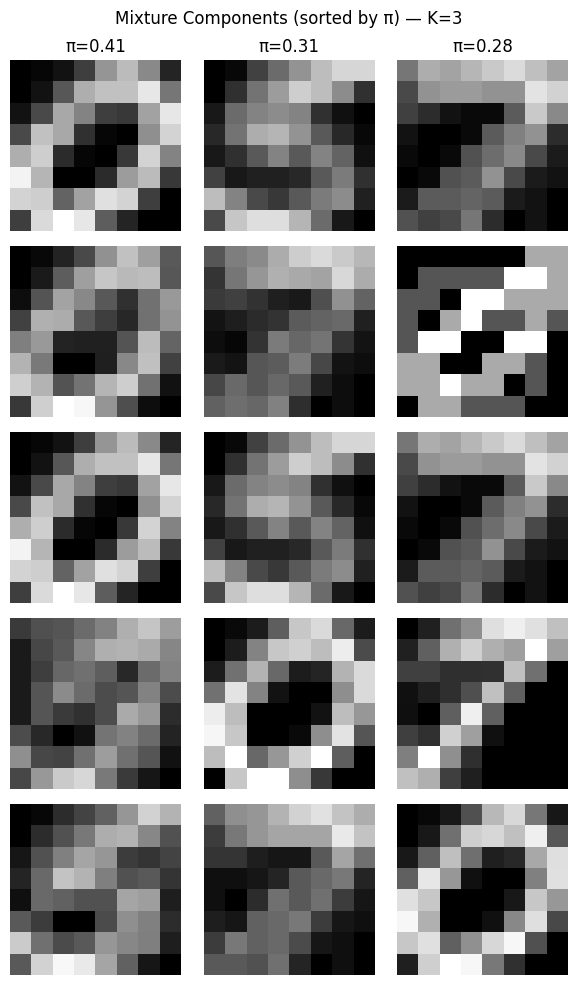

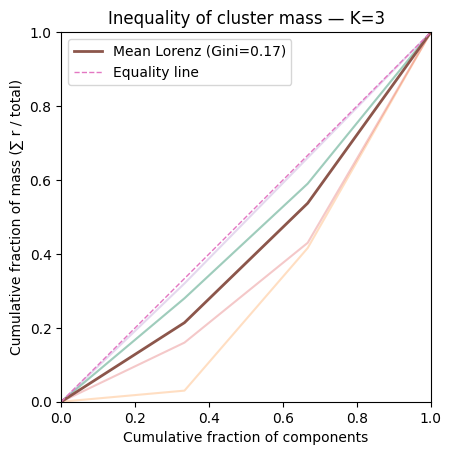

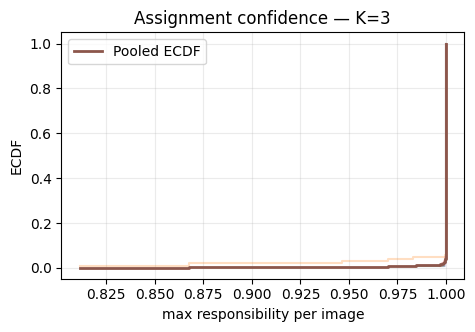

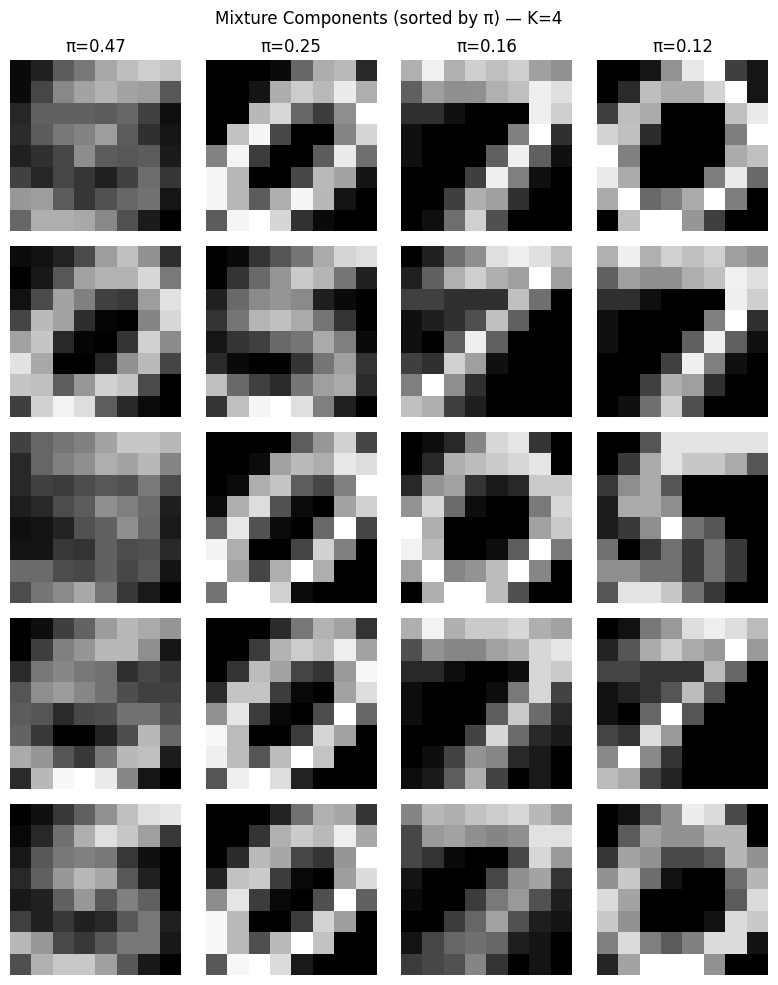

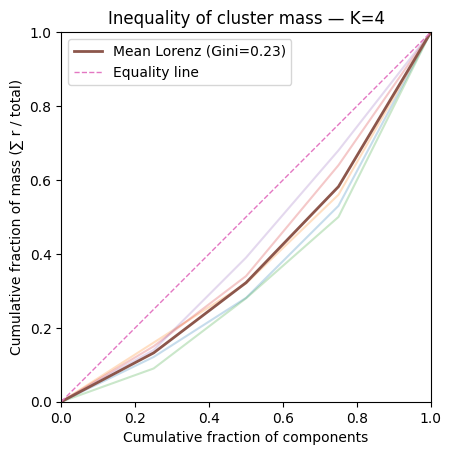

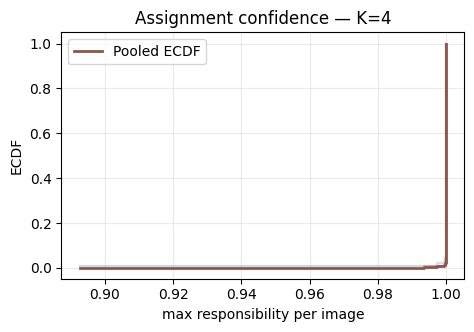

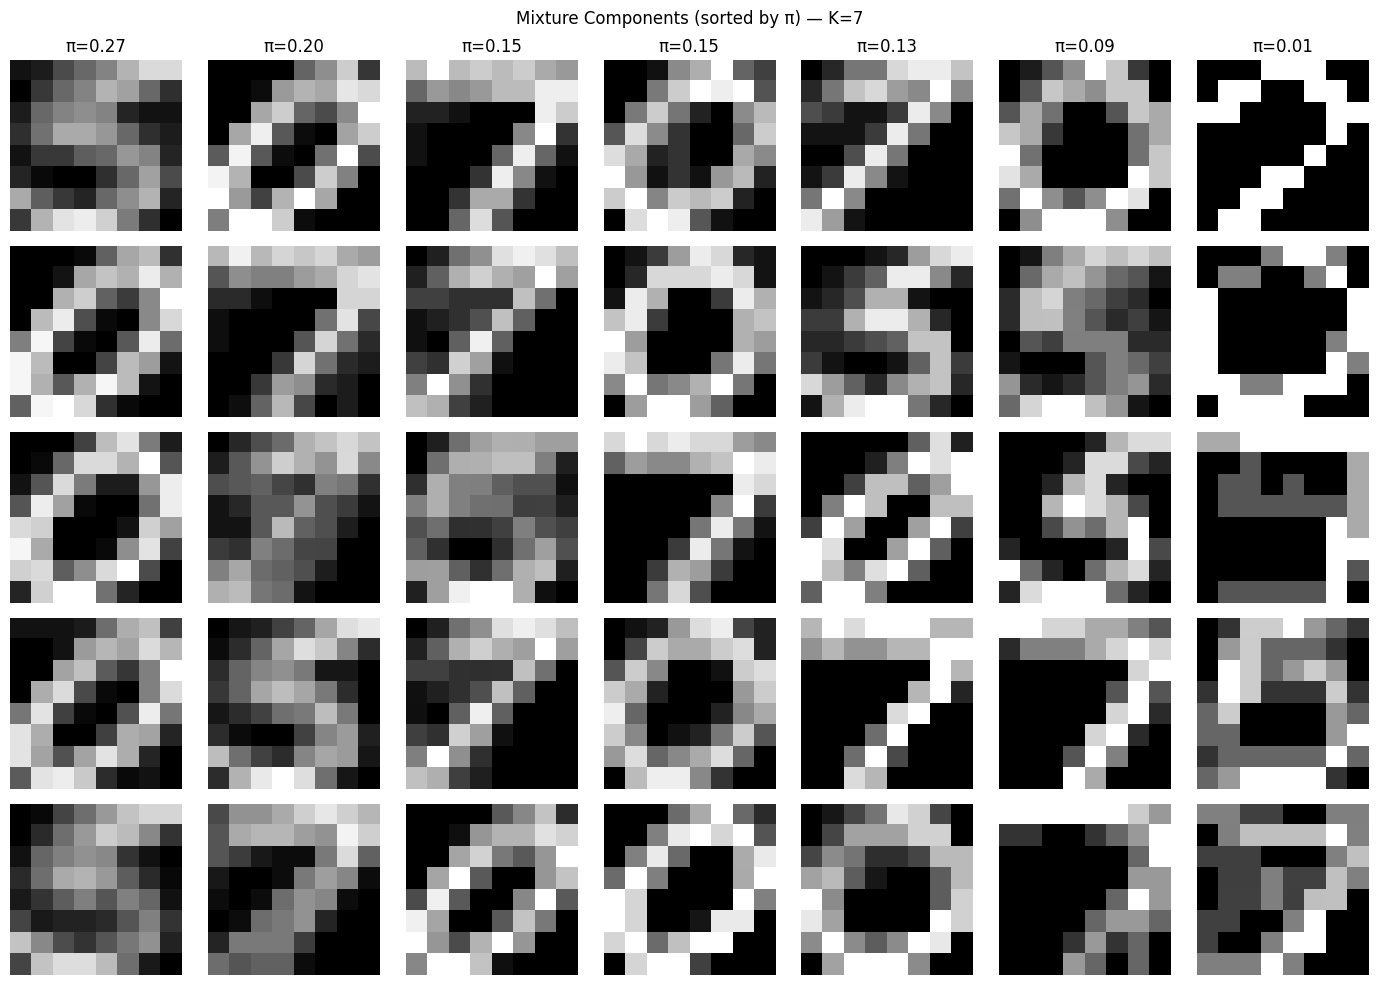

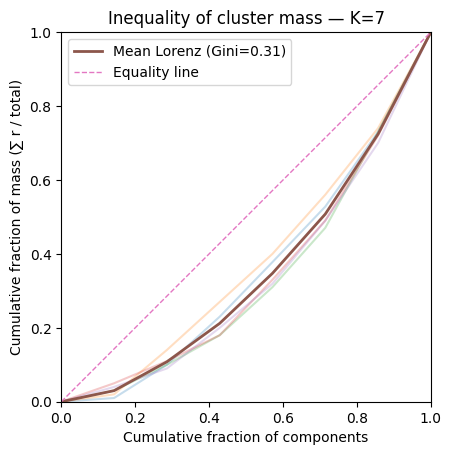

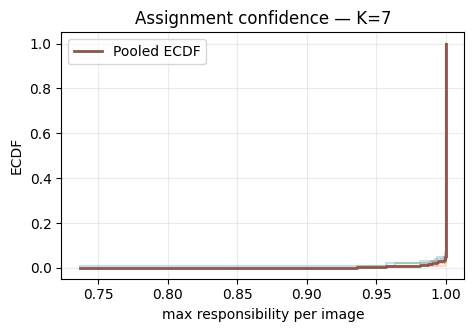

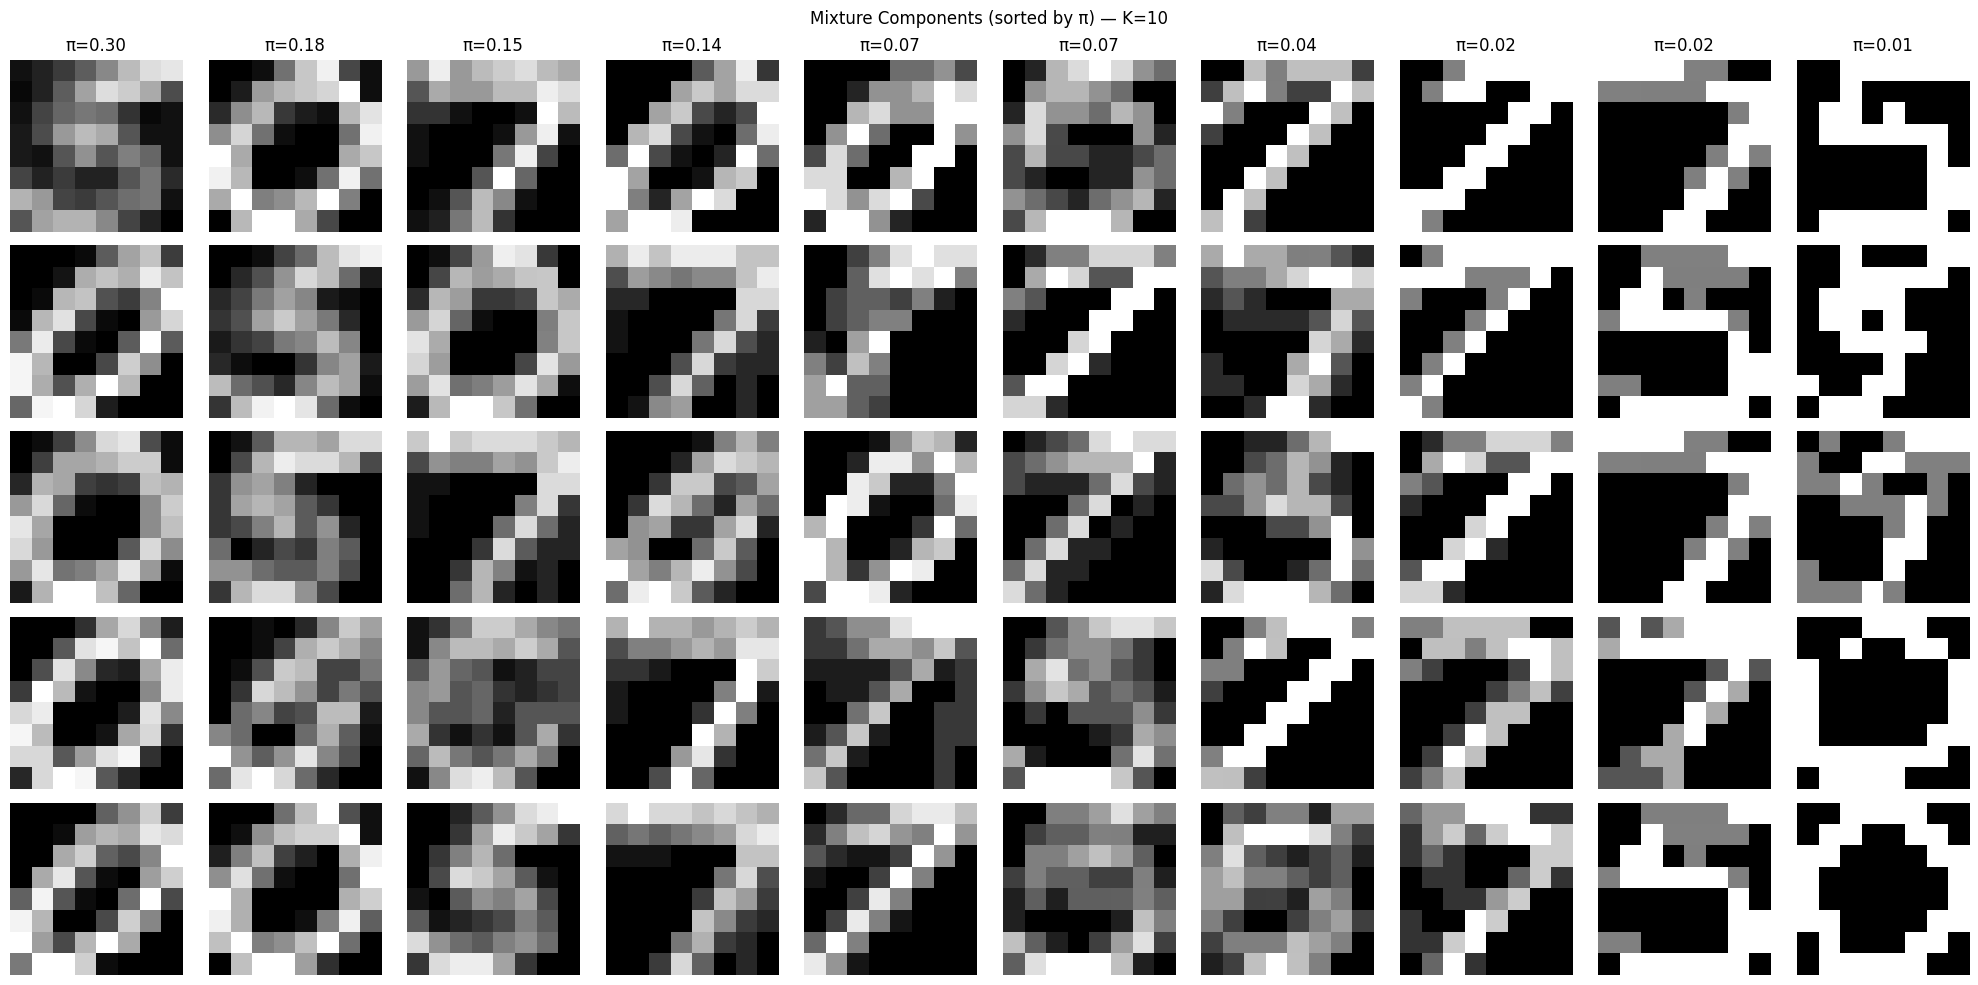

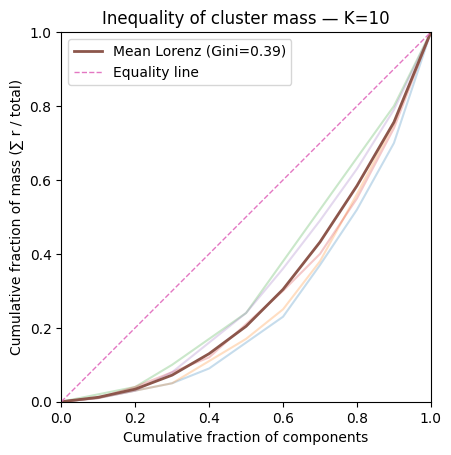

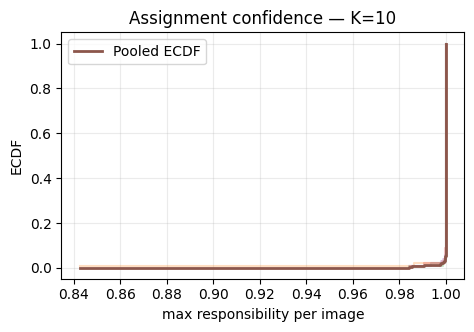

In [12]:
import numpy as np
import matplotlib.pyplot as plt

n_repeats = 5

for idxK, K in enumerate(mixtures):
    # Figure 1 (components grid) we still create now
    plt.figure(1 + idxK*3, figsize=(2*K, 2*n_repeats))

    # Collect per-repeat stats for figs 2 & 3
    masses = []   # list of (K,) arrays: normalised cluster mass per repeat
    confs  = []   # list of (N,) arrays: max responsibility per image per repeat

    for repeat in range(n_repeats):
        pi, P, r, ll, it, _ = em_run(K, data)

        # sort by π (descending) & align r
        order = np.argsort(-pi)
        pi = pi[order]
        P  = P[order, :]
        r  = r[:, order]

        # --- store stats for later plotting ---
        mass = r.sum(axis=0)            # (K,)
        mass = mass / mass.sum()        # normalise to sum=1
        masses.append(mass)

        conf = r.max(axis=1)            # (N,)
        confs.append(conf)

        # --- components grid: rows=repeats, cols=sorted components ---
        for k in range(K):
            idx = repeat*K + k + 1
            plt.subplot(n_repeats, K, idx)
            plt.imshow(P[k].reshape(8,8), cmap='gray', vmin=0, vmax=1, interpolation='nearest')
            if repeat == 0:
                plt.title(f"π={pi[k]:.2f}")
            plt.axis('off')

    # Finalise Figure 1
    plt.figure(1 + idxK*3)
    plt.suptitle(f"Mixture Components (sorted by π) — K={K}")
    plt.tight_layout()

    # -------------------------
    # Figure 2: Lorenz + Gini
    # -------------------------
    plt.figure(2 + idxK*3, figsize=(4.8, 4.8))

    # plot each repeat's Lorenz faintly
    ginis = []
    for mass in masses:
        share = np.sort(mass)                         # ascending shares
        cum_share = np.cumsum(share)
        cum_share = np.insert(cum_share, 0, 0.0)      # prepend 0
        x = np.linspace(0, 1, len(cum_share))         # cumulative fraction of clusters
        gini = 1.0 - 2.0 * np.trapezoid(cum_share, x)
        ginis.append(gini)
        plt.plot(x, cum_share, alpha=0.25)

    # mean curve (compute Lorenz on mean mass)
    mean_mass = np.mean(np.vstack(masses), axis=0)
    mean_mass = mean_mass / mean_mass.sum()
    share_m = np.sort(mean_mass)
    cum_share_m = np.cumsum(share_m)
    cum_share_m = np.insert(cum_share_m, 0, 0.0)
    x_m = np.linspace(0, 1, len(cum_share_m))
    gini_mean = 1.0 - 2.0 * np.trapezoid(cum_share_m, x_m)

    plt.plot(x_m, cum_share_m, lw=2, label=f"Mean Lorenz (Gini={gini_mean:.2f})")
    plt.plot([0,1],[0,1],'--',lw=1, label='Equality line')

    plt.xlabel("Cumulative fraction of components")
    plt.ylabel("Cumulative fraction of mass (∑ r / total)")
    plt.title(f"Inequality of cluster mass — K={K}")
    plt.legend()
    plt.axis('square'); plt.xlim(0,1); plt.ylim(0,1)

    # ---------------------------------
    # Figure 3: ECDF of max responsibility
    # ---------------------------------
    plt.figure(3 + idxK*3, figsize=(5.2, 3.2))

    # overlay per-repeat ECDFs faintly
    for conf in confs:
        x = np.sort(conf)
        y = np.arange(1, len(x)+1) / len(x)
        plt.plot(x, y, drawstyle='steps-post', alpha=0.25)

    # pooled ECDF (bold summary)
    conf_all = np.sort(np.concatenate(confs))
    y_all = np.arange(1, len(conf_all)+1) / len(conf_all)
    plt.plot(conf_all, y_all, drawstyle='steps-post', lw=2, label='Pooled ECDF')

    plt.xlabel("max responsibility per image")
    plt.ylabel("ECDF")
    plt.title(f"Assignment confidence — K={K}")
    plt.grid(alpha=0.25)
    plt.legend()

# (Optional) finally: plt.show()

Question 4

In [ ]:
from ssm_kalman import run_ssm_kalman
X = np.loadtxt('ssm_spins.txt')

theta1 = 2 * np.pi / 180
theta2 = 2 * np.pi / 90

A = 0.99*np.array([
    [np.cos(theta1), -np.sin(theta1), 0, 0],
    [np.sin(theta1),  np.cos(theta1), 0, 0],
    [0,               0,              np.cos(theta2), -np.sin(theta2)],
    [0,               0,              np.sin(theta2),  np.cos(theta2)]
])

Q = np.eye(4) - A @ A.T

C = np.array([
    [1,   0,   1,   0],
    [0,   1,   0,   1],
    [1,   0,   0,   1],
    [0,   0,   1,   1],
    [0.5, 0.5, 0.5, 0.5]
])

R = np.eye(C.shape[0])

Y0 = np.zeros(4)
Q0 = np.eye(4)

print("A:\n", A, "\n")
print("Q:\n", Q, "\n")
print("C:\n", C, "\n")
print("R:\n", R)
print("Y0:\n", Y0)
print("A0:\n", Q0)

A:
 [[ 0.98939692 -0.0345505   0.          0.        ]
 [ 0.0345505   0.98939692  0.          0.        ]
 [ 0.          0.          0.98758841 -0.06905891]
 [ 0.          0.          0.06905891  0.98758841]] 

Q:
 [[0.0199 0.     0.     0.    ]
 [0.     0.0199 0.     0.    ]
 [0.     0.     0.0199 0.    ]
 [0.     0.     0.     0.0199]] 

C:
 [[1.  0.  1.  0. ]
 [0.  1.  0.  1. ]
 [1.  0.  0.  1. ]
 [0.  0.  1.  1. ]
 [0.5 0.5 0.5 0.5]] 

R:
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]
Y0:
 [0. 0. 0. 0.]
A0:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [14]:
def logdet(A):
    L = np.linalg.cholesky(A)
    return 2 * np.sum(np.log(np.diag(L)))

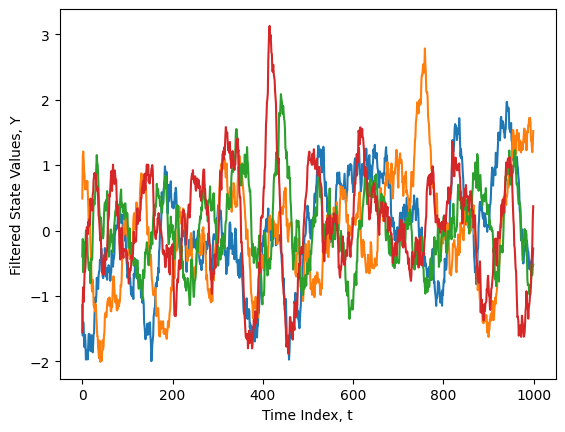

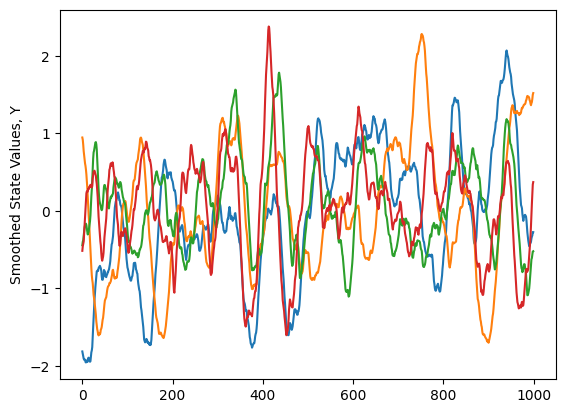

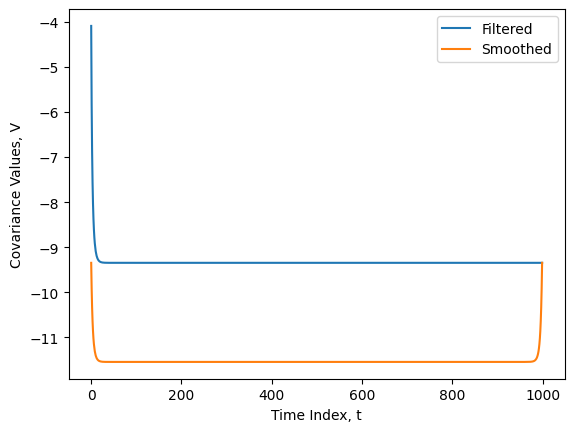

In [15]:
Y_filt,V_filt,_,L_filt = run_ssm_kalman(X.T,Y0,Q0,A,Q,C,R,'filt')
Y_smooth,V_smooth,Vj_smooth,L_smooth = run_ssm_kalman(X.T,Y0,Q0,A,Q,C,R,'smooth')

plt.figure()
plt.plot(Y_filt.T)
plt.xlabel('Time Index, t')
plt.ylabel('Filtered State Values, Y')
plt.show()

plt.figure()
plt.plot(Y_smooth.T)
plt.ylabel('Smoothed State Values, Y')
plt.show()

plt.figure(2)
plt.plot([logdet(V_t) for V_t in V_filt], label = 'Filtered')
plt.plot([logdet(V_t) for V_t in V_smooth], label = 'Smoothed')
plt.xlabel('Time Index, t')
plt.ylabel('Covariance Values, V')
plt.legend()
plt.show()



In [16]:
def compute_expectations(X_t, Y_t, V_t, Vj_t):
    """
    X_t
    Y_t
    V_t
    Vj_t
    """
    E_y = Y_t.T
    E_yyT = V_t + Y_t@Y_t.T
    E_yyprevT = Vj_t + Y_smooth[:, :-1]@Y_smooth[:,1:].T
    return E_y, E_yyT, E_yyprevT


def update_C(X_t, E_y, E_yyT):
    """
    X_t
    E_y
    E_yyT
    C_new
    """
    print(E_y.shape, X_t.shape, E_yyT.shape)
    C_new = (E_y @ X_t.T) @ np.linalg.inv(np.sum(E_yyT, axis = 1))
    return C_new

def update_R(X_t, E_y, C_new, T):
    """
    X_t
    E_y
    C_new
    T
    R_new
    """
    R_new = ((X_t@X_t.T) - ((X_t@E_y)@C_new.T))/T
    return R_new

def update_A(E_yyprevT, E_yyT):
    """
    E_yyprevT
    E_yyT
    A_new
    """
    A_new = np.sum(E_yyprevT, axis = 1) @ np.linalg.inv(np.sum(E_yyT, axis = 1))
    return A_new

def update_Q(E_yyT, E_yyprevT, A_new, T):
    """
    E_yyT
    E_yyprevT
    A_new
    T
    Q_new
    """
    Q_new = (np.sum(E_yyT, axis = 1) - (np.sum(E_yyprevT, axis = 1)@A_new.T))/(T-1)
    return Q_new


def e_step(X_t, Y_t, Q_t, A, Q, C, R):
    """
    """
    Y_t,V_t,Vj_t,L_t = run_ssm_kalman(X_t.T,Y_t,Q,A,Q,C,R,'smooth')
    E_y, E_yyT, E_yyprevT = compute_expectations(X_t, Y_t, V_t, Vj_t)
    return E_y, E_yyT, E_yyprevT, Y_t, V_t, Vj_t, L_t


def m_step(X_t, E_y, E_yyT, E_yyprevT):
    """
    """
    T = len(X_t)
    C_new = update_C(X_t, E_y, E_yyT)
    R_new = update_R(X_t, E_y, C_new, T)
    A_new = update_A(E_yyprevT, E_yyT)
    Q_new = update_Q(E_yyT, E_yyprevT, A_new, T)
    return A_new, Q_new, C_new, R_new


def batch_em_run(X_t, init_vals, max_iter=200, tol=1e-10):
    """
    """
    l_history = []
    delta = np.inf
    total_l_prev = -np.inf
    i = 0
    Y_t = init_vals['Y0']
    V_t = init_vals['Q0']
    A = init_vals['A']
    Q = init_vals['Q']
    C = init_vals['C']
    R = init_vals['R']
    while i<max_iter and delta>tol:
        E_y, E_yyT, E_yyprevT, Y_t, V_t, Vj_t, L_t = e_step(X_t, Y_t, V_t, A, Q, C, R)
        A, Q, C, R = m_step(X_t, E_y, E_yyT, E_yyprevT)
        total_l = np.sum(L_t, axis = 0)
        delta = total_l - total_l_prev
        l_history += [total_l]
        total_l_prev = total_l
        i += 1

    return A, Q, C, R

In [18]:
init_vals = {'Y0':Y0,
             'Q0':Q0,
             'A':A,
             'Q':Q,
             'C':C,
             'R':R,
             }

A, Q, C, R = batch_em_run(X, init_vals)

(1000, 4) (1000, 5) (1000, 4, 4)


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5 is different from 4)